<a href="https://colab.research.google.com/github/SebastianAblerKratkey/YFinance-Download-test/blob/main/temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import numpy_financial as npf
import pandas as pd
from pandas_datareader.data import DataReader as dr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
import mplfinance as mpf
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.stats import norm
import os
import datetime
import statsmodels.api as sm
import base64
from io import StringIO, BytesIO

# this module is utilized to prevent the annotations in the plot from overlapping
from adjustText import adjust_text

# Get Yahoo Finance Data
import yfinance as yf

# Library for Website creation
import streamlit as st
st.set_option('deprecation.showPyplotGlobalUse', False)

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
def convert_date_index(df):
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)
    # Extract the month and year from the datetime
    df.index = df.index.strftime("%b %Y")
    return df

def create_performance_index(price_df):
    returns = price_df.pct_change()
    growth = returns+1
    growth = growth.fillna(1) # set starting value for index
    index = growth.cumprod()
    index = index - 1 # deduct starting value to get the percentage change
    return index

def visualize_performance(prices, list_of_names):
    benchmarking_data = create_performance_index(prices)

    color_list = ['deepskyblue', 'steelblue', 'mediumslateblue', 'cornflowerblue', 'lightsteelblue',
                    'mediumslateblue', 'lightblue']

    benchmarking_data_filtered = benchmarking_data.filter(list_of_names)
    if len(list_of_names) > 0:
        benchmarking_data_filtered.plot(figsize=(15, 10), color=color_list)
    else:
        plt.figure(figsize=(15, 10))


    plt.fill_between(benchmarking_data.index, benchmarking_data.max(axis=1), benchmarking_data.min(axis=1),
                        color='grey', alpha=0.17, label="Range of all assets")

    # Calculate the number of days to add
    num_days = (benchmarking_data_filtered.index.max() - benchmarking_data_filtered.index.min()).days
    days_to_add1 = num_days / 120
    days_to_add2 = num_days / 12

    # Plot scatter points at the end of each line
    for col in benchmarking_data_filtered.columns:
        plt.scatter(benchmarking_data_filtered.index[-1], benchmarking_data_filtered[col].iloc[-1], color=color_list[list_of_names.index(col)], zorder=5)
        #text lablel is offset by a number of days to the right
        plt.text(benchmarking_data_filtered.index[-1] + pd.Timedelta(days=days_to_add1), benchmarking_data_filtered[col].iloc[-1], str(round(benchmarking_data_filtered[col].iloc[-1]*100, 2))+"%",color=color_list[list_of_names.index(col)], size=12, verticalalignment='bottom')

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    plt.gca().xaxis.set_major_locator(MaxNLocator())
    plt.gca().set_xlim(left=benchmarking_data.head(1).index.max())



    plt.xlim(right=benchmarking_data.index.max() + pd.Timedelta(days=days_to_add2))  # Extend x-axis limit by number of days
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format dates to show month and year
    plt.grid('on', ls="--")
    plt.ylabel(f"Performance (indexed: {benchmarking_data.head(1).index.max().strftime('%d.%m.%Y')} = 0%)", fontsize=12)
    plt.legend(fontsize=12)

    # Rotate x-axis labels to be horizontal
    plt.xticks(rotation=0, ha='center')

    # Remove x-axis label
    plt.gca().set_xlabel('')

    plt.show()

def visualize_summary(summary):
    fontsize=8
    plt.rc('font', size=fontsize)
    fig, (ax1, ax2) = plt.subplots(1, 2, clip_on=False)
    ax1.grid('on', ls="--")
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(False)
    ax2.grid('on', ls="--")
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(False)
    ax3 =  ax2.twiny()
    ax4 = ax1.twiny()
    ax1.xaxis.set_major_locator(MaxNLocator(nbins="auto"))
    ax2.xaxis.set_major_locator(MaxNLocator(nbins="auto"))
    ax3.xaxis.set_major_locator(MaxNLocator(nbins="auto"))
    ax4.xaxis.set_major_locator(MaxNLocator(prune='upper', nbins="auto"))
    x_dim = max(max(summary["mean return"]), max(summary['standard deviation'])) * 1.1
    height_of_fig = len(summary)*0.1
    ax1.set_position([0, 0, 0.35, height_of_fig])
    ax2.set_position([0.35, 0, 0.35, height_of_fig])
    ax1.set_xlim(left=0, right=x_dim)
    ax2.set_xlim(left=0, right=x_dim)
    ax3.set_xlim(left=0, right=x_dim)
    ax4.set_xlim(left=-x_dim, right=0)
    ax1.xaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    ax3.xaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    ax4.xaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    ax1.invert_xaxis()
    ax2.tick_params(left = False, bottom=False)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    summary_sorted = summary.copy()
    summary_sorted["r/std"] = summary["mean return"] / summary['standard deviation']
    summary_sorted.sort_values("r/std", inplace=True)
    bar_width = 0.6  # Set a fixed width for the horizontal bars
    for index, row in summary_sorted.iterrows():
        ax1.barh(index, row['standard deviation'], height=bar_width, color="steelblue")
        ax2.barh(index,  row['mean return'], height=bar_width, color="deepskyblue")
        if row['mean return'] < 0:
            if abs(row['mean return']) > abs(row['standard deviation']):
                ax1.barh(index, abs(row['mean return']), height=bar_width, color="deepskyblue")
                ax1.barh(index, row['standard deviation'], height=bar_width, color="steelblue")
            if abs(row['mean return']) <= abs(row['standard deviation']):
                ax1.barh(index, row['standard deviation'], height=bar_width, color="steelblue")
                ax1.barh(index, abs(row['mean return']), height=bar_width, color="deepskyblue")
    ax1_patch = mpatches.Patch(color='deepskyblue', label='Mean return')
    ax1.legend(handles=[ax1_patch], fontsize=fontsize, frameon=False, loc='center', ncol=2, bbox_to_anchor=(1, 1+0.8/len(summary)))
    ax2_patch = mpatches.Patch(color='steelblue', label='Volatility')
    ax2.legend(handles=[ax2_patch], fontsize=fontsize, frameon=False, loc='center', ncol=2, bbox_to_anchor=(0, -0.8/len(summary)))
    plt.show()


def visualize_correlation(corr):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["deepskyblue", "mediumslateblue", "slategrey"])
    mask = np.triu(corr, k=1)
    plt.figure(figsize=(12, 7))
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask, linewidths=5,
                annot_kws={'color':'white'})
    plt.show()

def portfolio_std(weights):
    portfolio_std = np.sum(weights * np.sum(weights * annualized_cov_returns, axis=1)) ** 0.5
    return portfolio_std

def portfolio_return(weights, returns):
    portfolio_return = np.sum(weights * returns)
    return portfolio_return

def negative_portfolio_SR(weights, rf, returns):
    return_p = portfolio_return(weights, returns)
    std_p = portfolio_std(weights)
    negative_sharpe_ratio = -1*(return_p - rf) / std_p
    return negative_sharpe_ratio

def negative_portfolio_utility(weights, returns):
    return_p = portfolio_return(weights, returns)
    std_p = portfolio_std(weights)
    negative_portfolio_utility = -1*(return_p - 0.5*A*std_p**2)
    return negative_portfolio_utility

def create_KPI_report(name, weights, rf, returns):
    KPIs = pd.DataFrame(index=[name])
    KPIs["portfolio return"] = portfolio_return(weights, returns)
    KPIs["protfolio std"] = portfolio_std(weights)
    KPIs["sharpe ratio"] = (KPIs["portfolio return"]- rf) / KPIs["protfolio std"]
    KPIs["utility"] = KPIs["portfolio return"] - 0.5*A*KPIs["protfolio std"]**2
    return KPIs

def create_portfolio_visual(name, summary, KPIs):
    plt.figure(figsize=(8, 8))
    plt.pie(summary["weight"], wedgeprops=dict(width=0.45),
            colors=['deepskyblue', 'steelblue', 'lightblue', 'lightsteelblue', 'cornflowerblue',
                    'mediumslateblue','thistle', 'dodgerblue', 'slategrey'],
            autopct='%.2f%%',pctdistance=0.8, startangle=90,labels=summary.index)
    plt.annotate(name, xy=(0,0), fontsize=30, va="center", ha="center")
    plt.annotate("E(r): {}%".format(float((KPIs["portfolio return"]*100).round(decimals=2))),
                 xy=(-0.07,-0.18), fontsize=10, va="center", ha="right")
    plt.annotate("Vola: {}%".format(float((KPIs["protfolio std"]*100).round(decimals=2))),
                 xy=(+0.07,-0.18), fontsize=10, va="center", ha="left")
    plt.show()

def create_mvf_cal_visual():
    #plot minimum varriance frontier and CAL
    color1 = 'cornflowerblue'
    color2 = 'darkmagenta'

    plt.figure(figsize=(15, 10))

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.2%}'.format))
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:,.2%}'.format))
    plt.gca().set_xlim(left=0)
    plt.gca().set_xlim(right=max(max(summary["standard deviation"]),float(KPIs_ocp["protfolio std"]))*1.05)

    plt.scatter(summary["standard deviation"], summary["mean return"], color=color1)

    # capital allocation line

    # between std = 0 and std = std_orp_l
    std_cal_1 = np.arange(0, float(KPIs_orp_l["protfolio std"]), step)
    return_cal_1 = rf_l + float(KPIs_orp_l["sharpe ratio"])*std_cal_1
    plt.plot(std_cal_1 ,return_cal_1, color=color1, label='Capital allocation line')

    # between std_orp_l and std_orp_b -> follows minimum varriance frontier
    mvf_plot_slice = mvf_plot_data[(mvf_plot_data["return"] >= float(KPIs_orp_l["portfolio return"])) &
                               (mvf_plot_data["return"] <= float(KPIs_orp_b["portfolio return"]))]
    std_cal_2 = mvf_plot_slice["std"]
    return_cal_2 = mvf_plot_slice["return"]
    plt.plot(std_cal_2,return_cal_2,color=color1)

    # after std_orp_b
    endpoint_cal = plt.gca().get_xlim()[1]
    std_cal_3 = np.arange(float(KPIs_orp_b["protfolio std"]), endpoint_cal, step)
    return_cal_3 = rf_b + float(KPIs_orp_b["sharpe ratio"])*std_cal_3
    plt.plot(std_cal_3 ,return_cal_3, color=color1)

    # minimum varriance frontier
    plt.plot(mvf_plot_data["std"], mvf_plot_data["return"], color=color1, linestyle='--',
         label='Minimum varriance frontier')

    plt.scatter(KPIs_mvp["protfolio std"], KPIs_mvp["portfolio return"], color=color2)
    plt.scatter(KPIs_orp["protfolio std"], KPIs_orp["portfolio return"], color=color2)
    plt.scatter(KPIs_ocp["protfolio std"], KPIs_ocp["portfolio return"], color=color2)

    plt.legend(fontsize=12)
    plt.xlabel("Volatility", fontsize=12)
    plt.ylabel("Mean return", fontsize=12)
    plt.grid('on', ls="--")

    # labeling
    x_offset = plt.gca().get_xlim()[1]*0.01
    for i in summary_p.index:
        plt.annotate(i,(summary_p["protfolio std"][i], summary_p["portfolio return"][i]),
                 (summary_p["protfolio std"][i]-x_offset, summary_p["portfolio return"][i]),
                 color=color2, fontsize=12, ha='right')

    labels = []
    for i in summary.index:
        labels.append(plt.text(summary["standard deviation"][i], summary["mean return"][i], i, size=8))
    adjust_text(labels)

    plt.show()

def currency_formatter_alt_EUR_decimal_seperator(x, currency="EUR"):
         if currency == 'EUR':
            return f'{currency} {x:,.2f}'.replace(",", "X").replace(".", ",").replace("X", ".")
         elif currency == 'USD':
            return f'{currency} {x:,.2f}'

def currency_formatter(x, currency="EUR"):
    return f'{currency} {x:,.2f}'

def currency_formatter_signs(x, currency="EUR"):
         if currency == 'EUR':
            return f'€ {x:,.2f}'
         elif currency == 'USD':
            return f'$ {x:,.2f}'

def visualize_simulaiton(sim_avg, deposits, currency='EUR'):
    """
    Plots the average simulated performance over time.

    Parameters:
    sim_avg (DataFrame): A DataFrame containing the average simulated performance.
    currency (str): The currency in which to display the performance data.

    Returns:
    None
    """
    def currency_formatter(x, pos):
         if currency == 'EUR':
            return f'€ {x:,.2f}'
         elif currency == 'USD':
            return f'$ {x:,.2f}'

    plt.figure(figsize=(15, 5))

    # Set the y-axis formatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

    # Set the tick locations and labels
    plt.xticks(sim_avg.index)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))

    # Plot the bars
    if sim_avg.iloc[-1] > deposits[-1]:
        plt.bar(sim_avg.index, sim_avg, color='deepskyblue', label="Capital", align='center')
        plt.bar(sim_avg.index, deposits, color='steelblue', label="Money invested", align='center')
    if sim_avg.iloc[-1] < deposits[-1]:
        plt.bar(sim_avg.index, deposits, color='steelblue', label="Money invested", align='center')
        plt.bar(sim_avg.index, sim_avg, color='deepskyblue', label="Capital", align='center')

    # Set the x-axis limits based on the minimum and maximum values in the index
    plt.gca().set_xlim(left=sim_avg.index.min()-0.8)
    plt.gca().set_xlim(right=sim_avg.index.max()+0.8)

    # Rotate xticks if needed
    if len(sim_avg.index) > 22:
        plt.xticks(rotation=45)
    if len(sim_avg.index) > 60:
        plt.xticks(rotation=90)
    if len(sim_avg.index) > 75:
        plt.gca().tick_params(axis='x', labelsize=8)

    plt.gca().set_axisbelow(True)
    plt.grid('on', ls="--")
    plt.gca().xaxis.grid(False)
    plt.legend(fontsize=12)

    plt.show()

def generate_excel_download_link(df):
    towrite = BytesIO()
    df.to_excel(towrite, index=False, header=True)
    towrite.seek(0)
    b64 = base64.b64encode(towrite.read()).decode()
    href = f'<a href="data:application/vnd.openxmlformats-officedocument.spreadsheetml.sheet;base64,{b64}" download="template.xlsx">Excel template'
    return st.markdown(href, unsafe_allow_html=True)

def maximum_drawdowns(price_df):
    """
    Calculate the maximum drawdowns of a dataframe of asset prices.

    Parameters:
    price_df (pd.DataFrame): A pandas DataFrame containing asset prices.
    (date index must be sorted ascending)

    Returns:
    pd.Series: Series of asset names and corresponding maximum drawdowns.
    """
    price_df_sorted = price_df.sort_index(ascending=True)
    max_price_df = price_df_sorted.rolling(window=len(price_df_sorted),min_periods=1).max()
    dd_price_df = price_df_sorted / max_price_df -1
    max_dd_series = dd_price_df.min()

    return max_dd_series

def get_monthly_closing_prices(price_df_daily):
    price_df_monthly = price_df_daily.loc[price_df_daily.groupby(price_df_daily.index.to_period('M')).apply(lambda x: x.index.max())]
    return price_df_monthly


def simulate_leveraged_daily_compounded_annual_return(daily_return,
                                                      daily_vola,
                                                      leverage,
                                                      reference_rate,
                                                      expense_ratio,
                                                      assumed_trading_days,
                                                      sim_runs):
    delta_t = 1/assumed_trading_days
    daily_leverage_cost = ((leverage-1)*reference_rate + expense_ratio)*delta_t

    # run monte carlo simmulation
    daily_return_sim = np.log(1 + leverage*(daily_return + daily_vola*np.random.normal(0, 1, size=(sim_runs, assumed_trading_days))) - daily_leverage_cost)

    daily_compounded_annual_returns = np.sum(daily_return_sim, axis=1)

    mean_daily_compounded_annual_return = daily_compounded_annual_returns.mean()
    std_daily_compounded_annual_return = daily_compounded_annual_returns.std()

    return mean_daily_compounded_annual_return, std_daily_compounded_annual_return

def create_leverage_sim_visual(results_df):
    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot mean return on primary y-axis
    ax1.scatter(results_df['Leverage'], results_df['Mean_Return'], label='Simulated return', color='cornflowerblue')
    ax1.set_xlabel('Leverage')
    ax1.set_ylabel('Daily compounded annual return')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))

    plt.grid('on', ls="--")
    # Create secondary y-axis for standard deviation
    ax2 = ax1.twinx()
    ax2.scatter(results_df['Leverage'], results_df['Std_Return'], label='Simulated volatility', color='darkmagenta')
    ax2.set_ylabel('Volatility of annual returns')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc=0)

    # Display the plot
    plt.show()

#Technical Analysis functions
def calculate_macd(data, price="Close", days_fast=12, days_slow=26, days_signal=9):
    short_ema = data[price].ewm(span=days_fast, adjust=False).mean()
    long_ema = data[price].ewm(span=days_slow, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=days_signal, adjust=False).mean()
    return short_ema, long_ema, macd, signal

def pandas_rsi(df: pd.DataFrame, window_length: int = 14, output: str = None, price: str = 'Close'):
    """
    An implementation of Wells Wilder's RSI calculation as outlined in
    his 1978 book "New Concepts in Technical Trading Systems" which makes
    use of the α-1 Wilder Smoothing Method of calculating the average
    gains and losses across trading periods and the Pandas library.

    @author: https://github.com/alphazwest
    Args:
        df: pandas.DataFrame - a Pandas Dataframe object
        window_length: int - the period over which the RSI is calculated. Default is 14
        output: str or None - optional output path to save data as CSV
        price: str - the column name from which the RSI values are calcuated. Default is 'Close'

    Returns:
        DataFrame object with columns as such, where xxx denotes an inconsequential
        name of the provided first column:
            ['xxx', 'diff', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi']
    """
    # Calculate Price Differences using the column specified as price.
    df['diff1'] = df[price].diff(1)

    # Calculate Avg. Gains/Losses
    df['gain'] = df['diff1'].clip(lower=0).round(2)
    df['loss'] = df['diff1'].clip(upper=0).abs().round(2)

    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Calculate Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length

    # Calculate Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length

    # Calculate RS Values
    df['rs'] = df['avg_gain'] / df['avg_loss']

    # Calculate RSI
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))

    # Save if specified
    if output is not None:
        df.to_csv(output)

    return df


In [77]:
asset_name = "AAPL"
asset_data = yf.download(asset_name)

days_back_period = 200

days_ema = 50

asset_data = asset_data.tail(days_back_period)

period_RSI=14
asset_data = pandas_rsi(df=asset_data, window_length=period_RSI, price="Close")
asset_data["70_line"] = 70
asset_data["30_line"] = 30

asset_data["macd_short_ema"], asset_data["macd_long_ema"], asset_data["macd"], asset_data["macd_signal"] = calculate_macd(asset_data, price="Close", days_fast=12, days_slow=26, days_signal=9)
asset_data["macd_hist"] = asset_data["macd"] - asset_data["macd_signal"]

# calculate addplot data
asset_data["ema"] = asset_data["Close"].ewm(span=days_ema, adjust=False).mean()

asset_data = asset_data.dropna()

#date formating
if days_back_period <= 270:
    date_format = '%b %d %Y'
else:
    date_format = '%b %Y'

[*********************100%%**********************]  1 of 1 completed
<ipython-input-10-97593d70bffd>:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df[price].diff(1)
<ipython-input-10-97593d70bffd>:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gain'] = df['diff1'].clip(lower=0).round(2)
<ipython-input-10-97593d70bffd>:402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

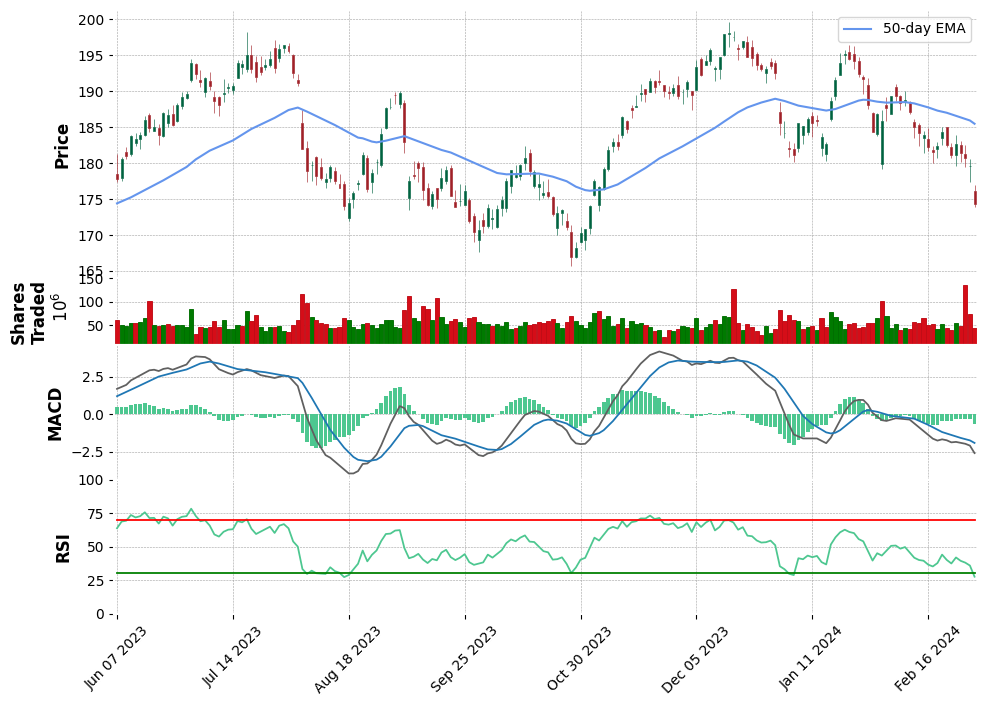

In [84]:
add_plots = [

mpf.make_addplot(data=asset_data["ema"], type="line", width=1.5, color="cornflowerblue", label=f"{days_ema}-day EMA"),

mpf.make_addplot((asset_data['macd']), color='#606060', panel=2, ylabel='MACD', secondary_y=False),

mpf.make_addplot((asset_data['macd_signal']), color='#1f77b4', panel=2, secondary_y=False),

mpf.make_addplot((asset_data['macd_hist']), type='bar', color='#4dc790', panel=2),

mpf.make_addplot(asset_data['rsi'], ylim=[0, 100], color='#4dc790', panel=3, ylabel='RSI', secondary_y=False),
mpf.make_addplot(asset_data['70_line'], color='r', panel=3, secondary_y=False),
mpf.make_addplot(asset_data['30_line'], color='g', panel=3, secondary_y=False)

]


s  = mpf.make_mpf_style(base_mpf_style="charles", y_on_right=False)

mpf.plot(
        asset_data,
        datetime_format=date_format,
        type="candle",
        ylabel_lower='Shares\nTraded',
        volume=True,
        style=s,
        addplot=add_plots,
        xlim=(asset_data.head(1).index.max() - pd.Timedelta(days=1), asset_data.tail(1).index.max()+ pd.Timedelta(days=1)),
        panel_ratios=(4,1,2,2),
        figscale=1.5
    )




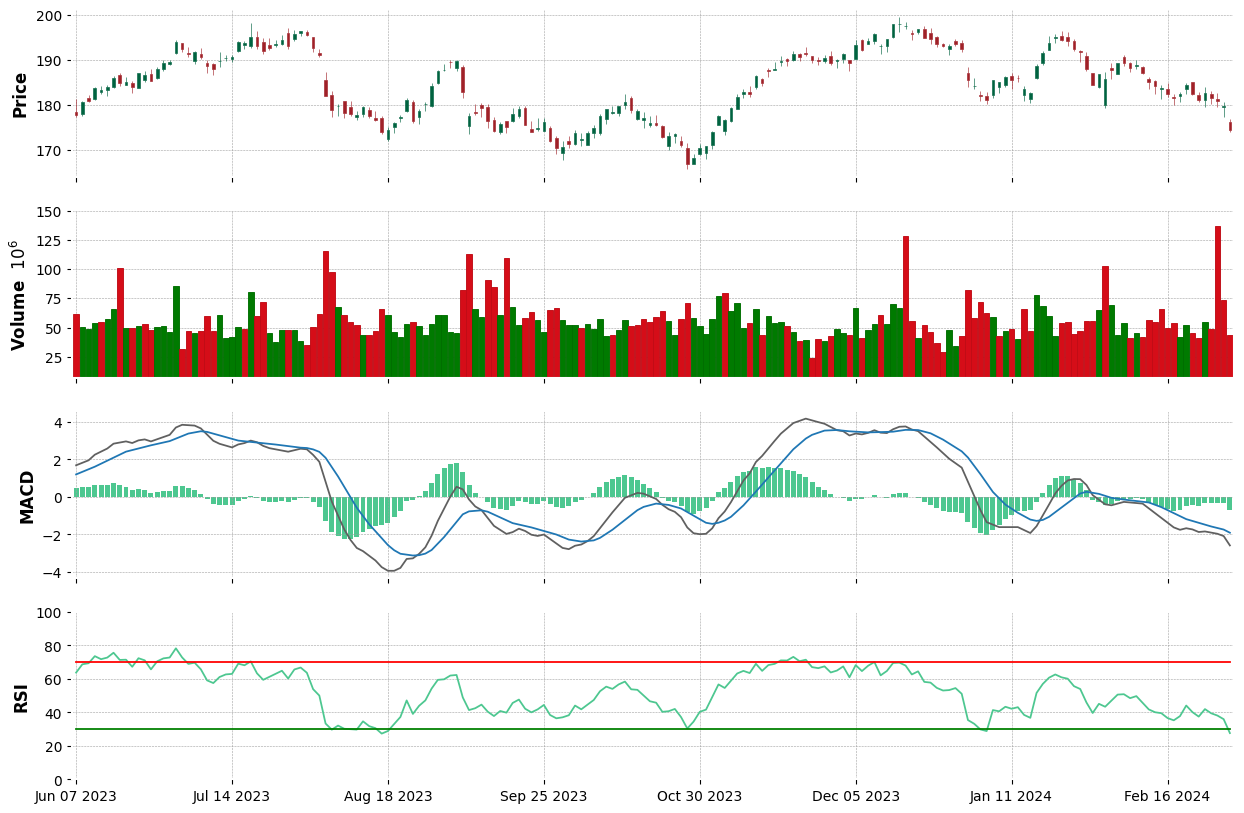

In [104]:
s  = mpf.make_mpf_style(base_mpf_style="charles", y_on_right=False)

fig = mpf.figure(style=s,figsize=(15,10))
ax4 = fig.add_subplot(4,1,4)
ax1 = fig.add_subplot(4,1,1, sharex=ax4)
ax2 = fig.add_subplot(4,1,2, sharex=ax4)
ax3 = fig.add_subplot(4,1,3, sharex=ax4)


ap0 = [
    # macd
    mpf.make_addplot((asset_data['macd']), color='#606060', ylabel='MACD', ax=ax3),
    mpf.make_addplot((asset_data['macd_signal']), color='#1f77b4', ax=ax3),
    mpf.make_addplot((asset_data['macd_hist']), type='bar', color='#4dc790', ax=ax3),

    #rsi
    mpf.make_addplot(asset_data['rsi'], ylim=[0, 100], color='#4dc790', ylabel='RSI', ax=ax4),
    mpf.make_addplot(asset_data['70_line'], color='r', ax=ax4),
    mpf.make_addplot(asset_data['30_line'], color='g', ax=ax4)
    ]

mpf.plot(asset_data,
         ax=ax1,
         addplot=ap0,
         volume=ax2,
         datetime_format=date_format,
         xlim=(asset_data.head(1).index.max() - pd.Timedelta(days=1), asset_data.tail(1).index.max()+ pd.Timedelta(days=1)),
         type="candle")

fig.subplots_adjust(hspace=0.2)
ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
ax3.tick_params(labelbottom=False)
ax3.yaxis.set_label_position('left')
ax3.yaxis.tick_left()


plt.show()

In [122]:
from matplotlib import gridspec
gs  = gridspec.GridSpec(4, 1, height_ratios=[4,1,2,2])

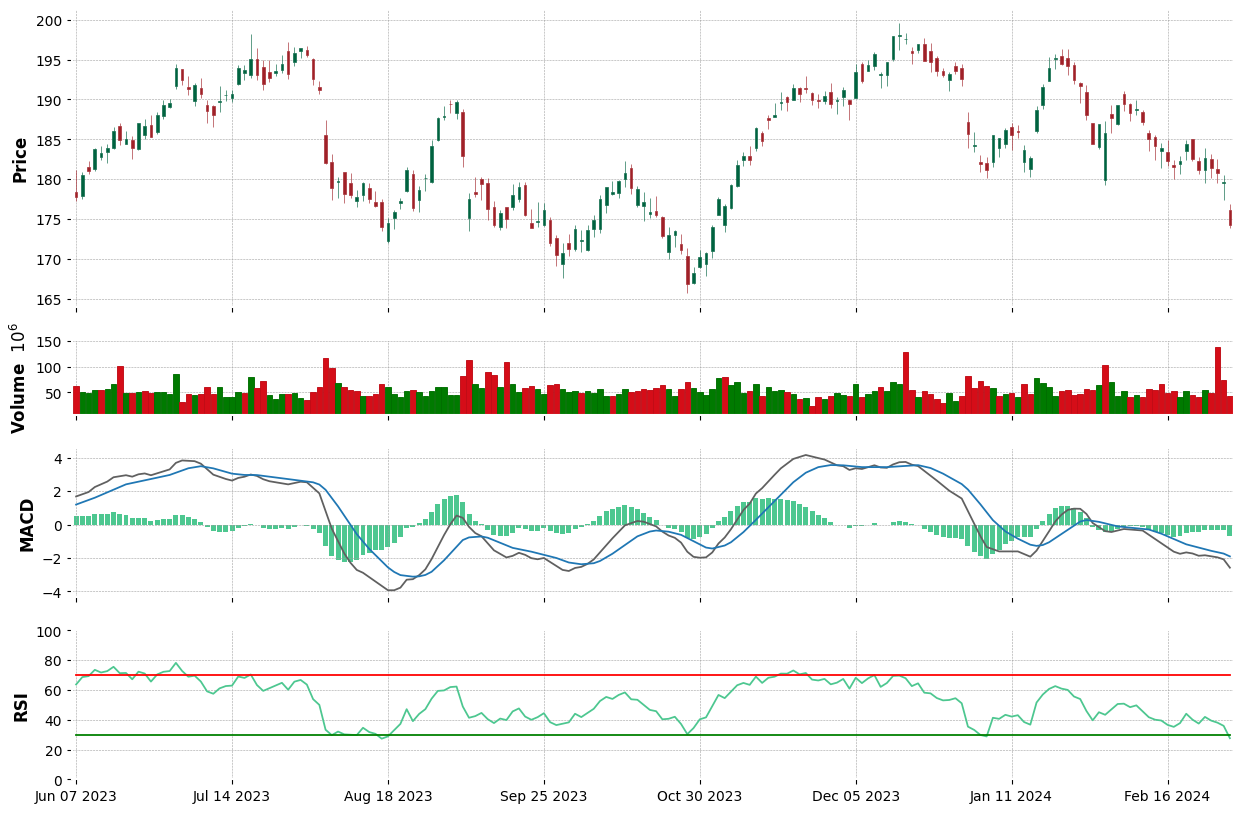

In [130]:
from matplotlib import gridspec

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(4, 1, height_ratios=[4,1,2,2])

ax4 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex=ax4)
ax2 = plt.subplot(gs[1], sharex=ax4)
ax3 = plt.subplot(gs[2], sharex=ax4)

ap0 = [
    # macd
    mpf.make_addplot((asset_data['macd']), color='#606060', ylabel='MACD', ax=ax3),
    mpf.make_addplot((asset_data['macd_signal']), color='#1f77b4', ax=ax3),
    mpf.make_addplot((asset_data['macd_hist']), type='bar', color='#4dc790', ax=ax3),

    # rsi
    mpf.make_addplot(asset_data['rsi'], ylim=[0, 100], color='#4dc790', ylabel='RSI', ax=ax4),
    mpf.make_addplot(asset_data['70_line'], color='r', ax=ax4),
    mpf.make_addplot(asset_data['30_line'], color='g', ax=ax4)
]

s = mpf.make_mpf_style(base_mpf_style="charles", y_on_right=False)

mpf.plot(asset_data,
         ax=ax1,
         style=s,
         addplot=ap0,
         volume=ax2,
         datetime_format=date_format,
         xlim=(asset_data.head(1).index.max() - pd.Timedelta(days=1), asset_data.tail(1).index.max() + pd.Timedelta(days=1)),
         type="candle")
fig.subplots_adjust(hspace=0.2)
ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
ax3.tick_params(labelbottom=False)
ax3.yaxis.set_label_position('left')
ax3.yaxis.tick_left()

plt.show()